Задание 5 - 20 баллов

*   Загрузить набор данных Lenta.ru с помощью пакета Corus
*   Обучить LDA модель, постараться подобрать адекватные параметры (num_topics, passes, alpha, iterations…) - 4 балла
*   Визуализировать результаты работы LDA с помощью pyLDAvis - 2 балла
*   Посчитать внутренние метрики обученных моделей LDA (с разными параметрами) и сравнить, соответствует ли метрика визуальному качеству работы моделей - 2 балла
*   Обучить модель BigARTM, использовать не менее двух регуляризаторов, оценить качество с помощью метрик - 5 баллов
*   Реализовать визуализацию топиков BigARTM через pyLDAvis - 4 балла
*   Обеспечена воспроизводимость решения: зафиксированы random_state, ноутбук воспроизводится от начала до конца без ошибок - 2 балла
*   Соблюден code style на уровне pep8 и On writing clean Jupyter notebooks - 1 балл

Примечание: подбирать параметры теметической модели можно также, как и для любой другой модели - на кроссвалидации, ориентируясь на метрики качества

In [400]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [401]:
%%capture
# !pip install corus
# !pip install nltk
# !pip install pymorphy2
# !pip install gensim pyLDAvis
!pip install bigartm

!wget https://github.com/yutkin/Lenta.Ru-News-Dataset/releases/download/v1.1/lenta-ru-news.csv.bz2

In [399]:
import pandas as pd
import numpy as np
import re
import nltk
import artm
import string
from pprint import pprint

from nltk.tokenize import (
    sent_tokenize,
    word_tokenize,
    TweetTokenizer,
    WordPunctTokenizer,
    WhitespaceTokenizer,
    LegalitySyllableTokenizer,
    SyllableTokenizer,
    MWETokenizer,
)

from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, LancasterStemmer, SnowballStemmer, WordNetLemmatizer

from corus import load_lenta2
import pymorphy2

import gensim
from gensim.utils import simple_preprocess
from gensim import corpora
from gensim.models.ldamodel import LdaModel
from gensim.corpora.dictionary import Dictionary
from sklearn.model_selection import ParameterGrid
from gensim.models.coherencemodel import CoherenceModel
from gensim.models import CoherenceModel

import pyLDAvis
import pyLDAvis.gensim_models as gensimvis

from collections import Counter

import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import matplotlib.colors as mcolors

import tqdm

from sklearn.feature_extraction.text import CountVectorizer
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe

In [402]:
path = 'lenta-ru-news.csv.bz2'
records = load_lenta2(path)

In [403]:
nltk.download('stopwords')
nltk.download('gutenberg')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package gutenberg to /root/nltk_data...
[nltk_data]   Package gutenberg is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [404]:
dataset = [next(records).text for i in range(10000)]

Очистка данных:

In [405]:
for i in range(len(dataset)):
  dataset[i] = re.sub(r'https?:\/\/.\S+', "", dataset[i]) #remove links
  dataset[i] = dataset[i].lower() #make each symbol in lowercase
  dataset[i] = re.sub('\n', ' ', dataset[i]) #replace line breaks with spaces
  dataset[i] = re.sub(r'[^\w\s]', ' ', dataset[i]) #remove punctuation
  dataset[i] = re.sub(r'[0-9]', '', dataset[i]) #remove numbers
  while '  ' in dataset[i]:
    dataset[i] = re.sub('  ', ' ', dataset[i]) #remove double spaces

Разобьем новости на слова, получим список списков:

In [406]:
data = []

for i in range(len(dataset)):
  data.append(dataset[i].split())

In [407]:
data[0][:10]

['бои',
 'у',
 'сопоцкина',
 'и',
 'друскеник',
 'закончились',
 'отступлением',
 'германцев',
 'неприятель',
 'приблизившись']

Удаление стоп-слов. Добавила свои стоп-слова, так как они портили вид графиков по топикам:

In [408]:
with open('/content/stopwords-ru.txt', 'r') as f:
    myStop = [line.strip() for line in f]

In [409]:
russian_stopwords = stopwords.words("russian") + myStop

In [410]:
len(russian_stopwords)

710

In [411]:
morph = pymorphy2.MorphAnalyzer()

In [412]:
clean_data = []

for sent in data:
  sent = [morph.parse(word)[0].normal_form for word in sent if word not in russian_stopwords]

  clean_data.append(sent)

In [413]:
len(clean_data)

10000

Лемматизация:

Создадим биграмы и триграмы:

In [439]:
bigram = gensim.models.Phrases(clean_data, min_count=5, threshold=100)
trigram = gensim.models.Phrases(bigram[clean_data], threshold=100)
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

In [440]:
def get_ngrams(texts):
    texts = [bigram_mod[doc] for doc in texts]
    texts = [trigram_mod[bigram_mod[doc]] for doc in texts]
    return texts

In [441]:
clean_data = get_ngrams(clean_data)

In [442]:
for item in clean_data:
  for token in item:
    if len(item) < 40 and '_' in token:
      print(token)

учебный_заведение
подземный_толчок
северо_запад
подземный_толчок
сила_балл_шкала
вызвать_паника
местный_житель
космический_станция
сообщить_корреспондент_итар
илья_клебанов
санкт_петербург
илья_клебанов
массовый_коммуникация
эхо_москва
правоохранительный_орган
медицинский_помощь
северный_осетия
министр_внутренний
владимир_рушайло
начальник_генеральный
вооружённый_сила
анатолий_квашнин
народный_ополчение
повышение_эффективность
обеспечение_правопорядок
северный_кавказ
борис_ельцин
нью_йорк
совет_федерация_егор_строев
борис_ельцин
пресс_секретарь
дмитрий_якушкин
корреспондент_итар_тасс
минувший_воскресение
жилой_дом
предварительный_данные
газовый_баллон
сообщать_риа_новость
второй_этаж
пятиэтажный_дом
сообщить_радиостанция_эхо
агентство_риа_новость
опасный_находка
агентство_риа_новость
северо_восточный
старопромысловский_район_грозный
нефтеперерабатывающий_завод
миллиард_доллар
внешний_долг
грамм_тротил
санкт_петербург
пресс_центр
корреспондент_итар_тасс
место_происшествие
патрульный_пос

In [443]:
id2word = corpora.Dictionary(clean_data)

In [444]:
corpus = [id2word.doc2bow(text) for text in clean_data]
corpus[1][:10]

[(28, 1),
 (71, 1),
 (78, 1),
 (79, 1),
 (80, 1),
 (81, 1),
 (82, 1),
 (83, 1),
 (84, 1),
 (85, 1)]

Обучим модель LDA:

In [ ]:
param_grid = {
    'num_topics': [5, 7, 10, 15],
    'iterations': [100, 200],
    'chunksize': [50, 100, 200],
    'passes': [20, 40]
}

Перебор кучи параметров для подбора лучших. Думает 4 часа, поэтому запускать не советую!

In [ ]:
%%time

grid = ParameterGrid(param_grid)

for params in grid:
    alpha = [100] * params['num_topics']
    eta=[0.01] * len(id2word)

    model = LdaModel(corpus=corpus, id2word=id2word, alpha=alpha, eta=eta, **params)

    coherencemodel = CoherenceModel(model=model, texts=clean_data, dictionary=id2word, coherence='c_v')
    coherence = coherencemodel.get_coherence()
    perplexity = model.log_perplexity(corpus)

    pprint(model.print_topics())

    best_coherence = coherence
    best_model = model
    best_params = params

    print(f"Model: {best_params}")
    print(f'Parameters: {params}')
    print(f"Coherence: {best_coherence}")
    print(f"Perplexity: {perplexity}")
    print("----------------------------------------------------\n")

[(0,
  '0.030*"чечня" + 0.027*"сообщить" + 0.023*"российский" + 0.017*"боевик" + '
  '0.016*"сотрудник" + 0.015*"задержать" + 0.014*"военный" + 0.014*"район" + '
  '0.013*"данные" + 0.013*"интерфакс"'),
 (1,
  '0.037*"человек" + 0.022*"время" + 0.020*"один" + 0.018*"сообщать" + '
  '0.017*"тысяча" + 0.017*"результат" + 0.016*"около" + 0.015*"два" + '
  '0.015*"находиться" + 0.014*"произойти"'),
 (2,
  '0.054*"который" + 0.031*"это" + 0.030*"свой" + 0.017*"однако" + '
  '0.017*"страна" + 0.016*"представитель" + 0.014*"суд" + 0.013*"закон" + '
  '0.012*"дело" + 0.012*"другой"'),
 (3,
  '0.062*"год" + 0.027*"компания" + 0.027*"который" + 0.018*"сша" + '
  '0.018*"новый" + 0.016*"интернет" + 0.015*"также" + 0.014*"процент" + '
  '0.012*"американский" + 0.011*"система"'),
 (4,
  '0.053*"россия" + 0.037*"президент" + 0.024*"заявить" + 0.022*"глава" + '
  '0.020*"решение" + 0.019*"принять" + 0.017*"правительство" + 0.015*"рф" + '
  '0.015*"слово" + 0.015*"отметить"')]
Model: {'chunksize': 50,

Лучшие параметры:

*   Model: {'chunksize': 100, 'iterations': 100, 'num_topics': 7, 'passes': 20}
*   Coherence: 0.445
*   Perplexity: -46.57







Посмотрим на эту модель:

In [445]:
%%time

lda_model = gensim.models.ldamodel.LdaModel(
    corpus=corpus,
    id2word=id2word,
    num_topics=7,
    random_state=20,
    update_every=1,
    chunksize=100,
    passes=20,
    alpha=[100]*7,
    iterations=100,
    per_word_topics=True,
    eta=[0.01]*len(id2word)
)

pprint(lda_model.print_topics())

[(0,
  '0.037*"чечня" + 0.024*"боевик" + 0.019*"район" + 0.016*"чеченский" + '
  '0.015*"находиться" + 0.014*"задержать" + 0.014*"республика" + '
  '0.013*"погибнуть" + 0.012*"город" + 0.011*"мвд"'),
 (1,
  '0.037*"компания" + 0.020*"интернет" + 0.016*"сайт" + 0.015*"информация" + '
  '0.014*"программа" + 0.014*"система" + 0.013*"суд" + 0.013*"доллар" + '
  '0.012*"американский" + 0.010*"акция"'),
 (2,
  '0.029*"президент" + 0.024*"решение" + 0.022*"правительство" + '
  '0.022*"принять" + 0.021*"глава" + 0.020*"закон" + 0.019*"россия" + '
  '0.014*"рф" + 0.014*"право" + 0.012*"государственный"'),
 (3,
  '0.029*"российский" + 0.013*"рубль" + 0.012*"россия" + 0.011*"слово" + '
  '0.010*"команда" + 0.009*"счёт" + 0.007*"журналист" + 0.007*"сообщать" + '
  '0.007*"связь" + 0.007*"предприятие"'),
 (4,
  '0.015*"июль" + 0.013*"июнь" + 0.012*"сша" + 0.011*"представитель" + '
  '0.011*"передавать" + 0.011*"слово" + 0.011*"российский" + 0.009*"сообщать" '
  '+ 0.008*"который" + 0.008*"заявить"'

In [446]:
coherencemodel = CoherenceModel(model=lda_model, texts=clean_data, dictionary=id2word, coherence='c_v')
coherence = coherencemodel.get_coherence()
perplexity = lda_model.log_perplexity(corpus)

print(f"Coherence: {coherence}, perplexity: {perplexity}")

Coherence: 0.4468570052189849, perplexity: -46.567594934918105


In [447]:
topics = lda_model.show_topics(formatted=False)
data_flat = [w for w_list in clean_data for w in w_list]
counter = Counter(data_flat)

out = {}
for i, topic in topics:
    if i not in out:
        out[i] = {'word': [], 'importance': [], 'word_count': []}
    for word, weight in topic:
        out[i]["word"].append(word)
        out[i]["importance"].append(weight)
        out[i]["word_count"].append(counter[word])

<ipython-input-448-1cd20109de1a>:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(out[i]['word'], rotation=30, horizontalalignment= 'right')


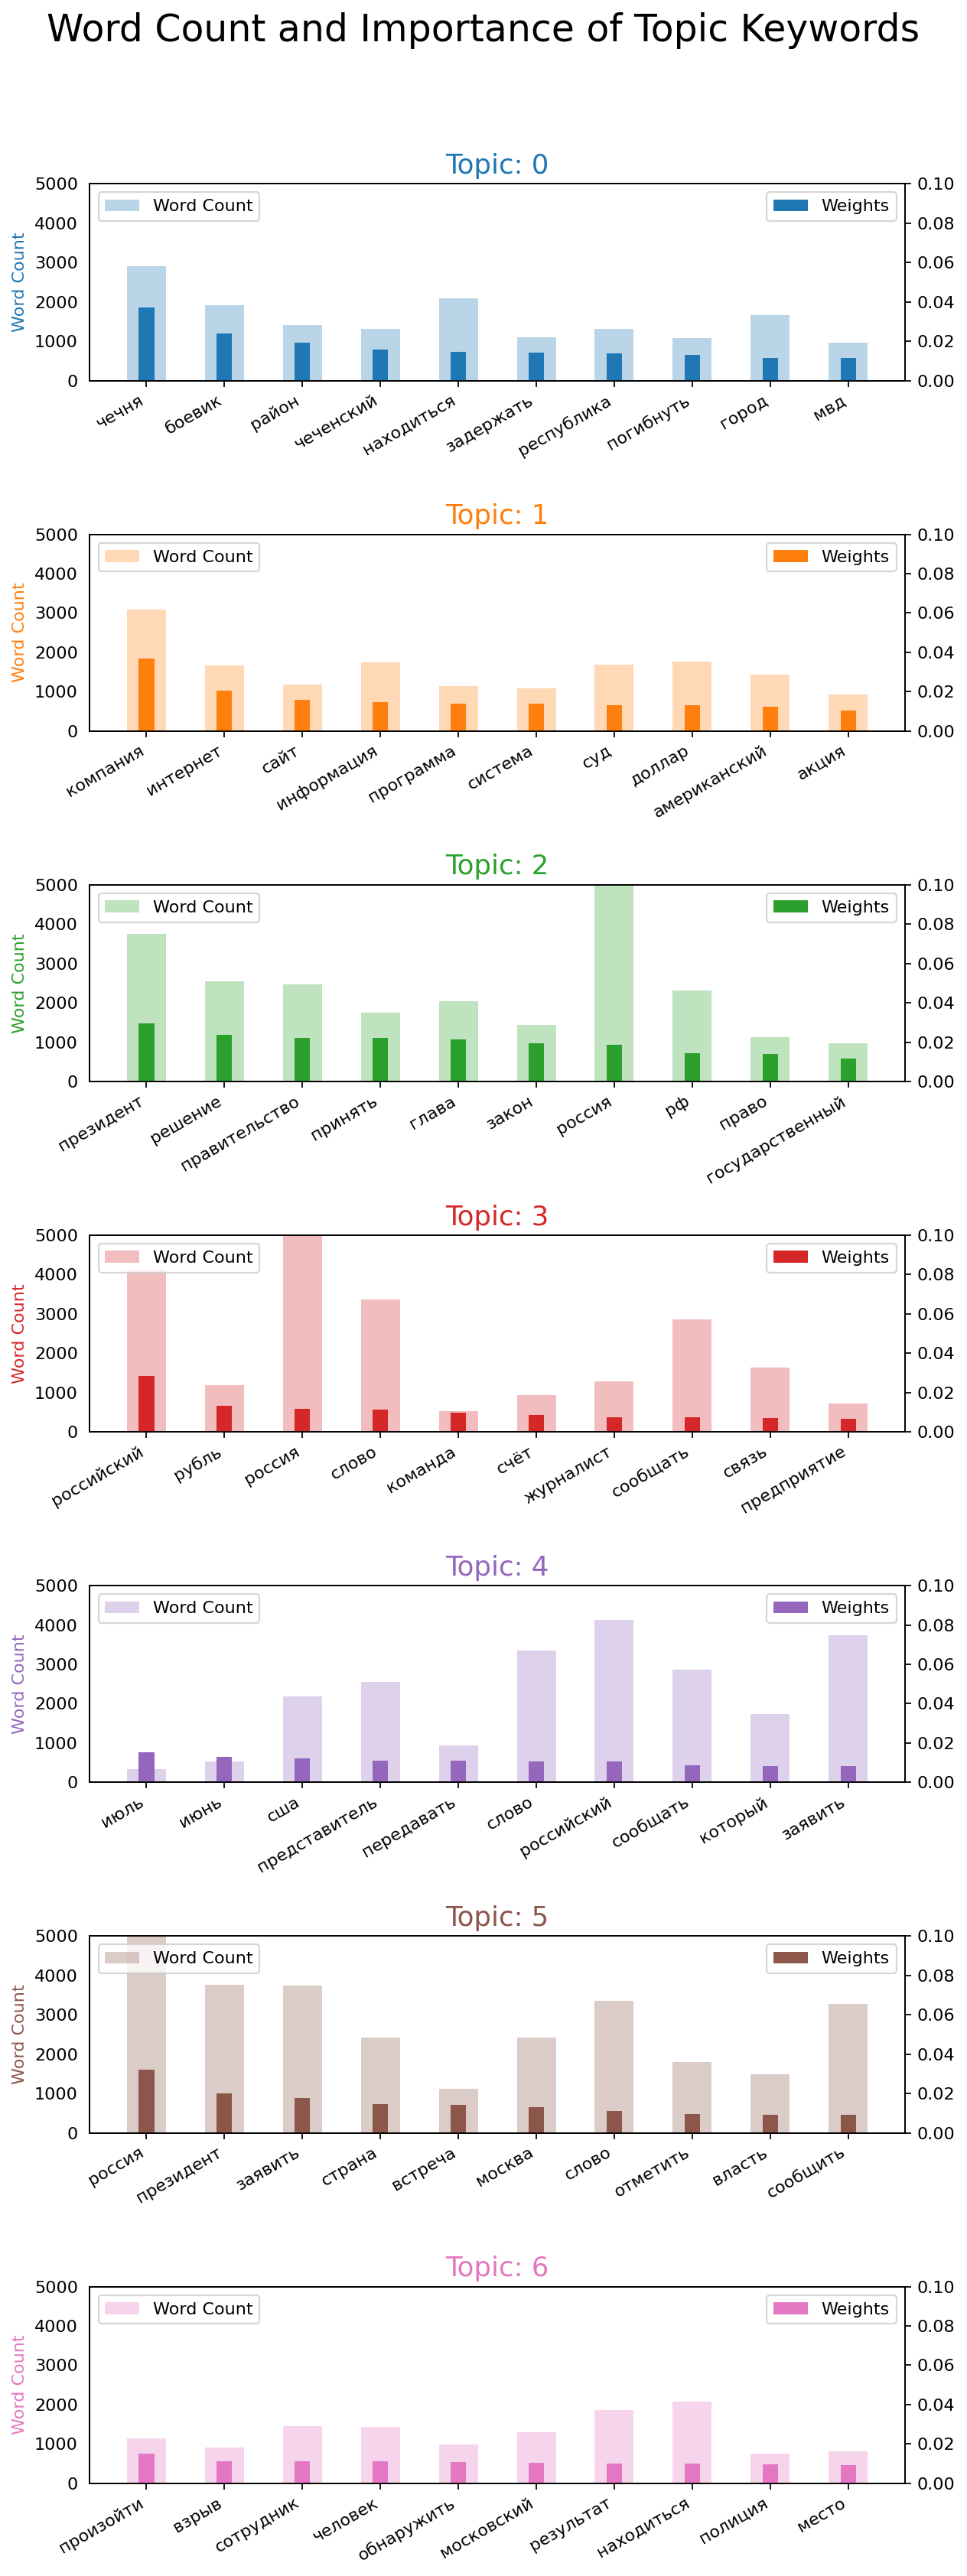

In [448]:
fig, axes = plt.subplots(7, 1, figsize=(8, 20), sharey=True, dpi=160)
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]
for i, ax in enumerate(axes.flatten()):
    ax.bar(x='word', height="word_count", data=out[i], color=cols[i], width=0.5, alpha=0.3, label='Word Count')
    ax_twin = ax.twinx()
    ax_twin.bar(x='word', height="importance", data=out[i], color=cols[i], width=0.2, label='Weights')
    ax.set_ylabel('Word Count', color=cols[i])
    ax_twin.set_ylim(0, 0.10); ax.set_ylim(0, 5000)
    ax.set_title('Topic: ' + str(i), color=cols[i], fontsize=16)
    ax.tick_params(axis='y', left=False)
    ax.set_xticklabels(out[i]['word'], rotation=30, horizontalalignment= 'right')
    ax.legend(loc='upper left'); ax_twin.legend(loc='upper right')

fig.tight_layout(w_pad=2)
fig.suptitle('Word Count and Importance of Topic Keywords', fontsize=22, y=1.05)
plt.show()

Попробуем обобщить значения слов в каждом топике:

*   Топик 0: чечня, что-то военное, боевики, гибель
*   Топик 1: сайт, компания, информация, интернет, система
*   Топик 2: президент, правительство, принятие решений, законы
*   Топик 3: российский, рубль, счёт, предприятие
*   Топик 4: сообщать, заявить, передавать слово
*   Топик 5: Россия, Москва, страна, власть
*   Топик 6: взрыв, полиция, место









In [449]:
pyLDAvis.enable_notebook()
vis = gensimvis.prepare(lda_model, corpus, dictionary=lda_model.id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.104036 -0.364917       1        1  14.441540
2      0.236513  0.212417       2        1  14.323550
5      0.106496  0.141774       3        1  14.315300
4      0.065925 -0.047021       4        1  14.302860
3      0.060950 -0.027119       5        1  14.294457
6     -0.233955  0.058772       6        1  14.185729
0     -0.339965  0.026092       7        1  14.136564, topic_info=            Term         Freq        Total Category  logprob  loglift
784     компания  4889.000000  4889.000000  Default  30.0000  30.0000
1220       чечня  5191.000000  5191.000000  Default  29.0000  29.0000
961    президент  6699.000000  6699.000000  Default  28.0000  28.0000
1120      боевик  3124.000000  3124.000000  Default  27.0000  27.0000
422       россия  9179.000000  9179.000000  Default  26.0000  26.0000
...          ...          ...          ...      ...      ...      ...
2532      теракт   807.622958  1051.104646   Topic7  -5.0829   1.6929
572     сообщить  1175.554378  4863.160197   Topic7  -4.7075   0.5365
2697  обнаружить   895.739366  2303.152970   Topic7  -4.9794   1.0120
1206   сотрудник   937.426509  3004.808993   Topic7  -4.9339   0.7916
1060         дом   738.626880  1333.096479   Topic7  -5.1722   1.3659

[491 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
451       6  0.996375      авария
451       7  0.004186      авария
1         6  0.939908  автомобиль
1         7  0.059207  автомобиль
2117      1  1.000307     адвокат
...     ...       ...         ...
929       3  0.076666    являться
929       4  0.274265    являться
929       5  0.158353    являться
929       6  0.003194    являться
594       4  0.998891      япония

[1080 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 3, 6, 5, 4, 7, 1])

#Векторизация текстов

In [421]:
clean_text = []

for text in clean_data:
  clean_text.append(' '.join(text))

In [422]:
vectorizer = CountVectorizer(max_features=1000, max_df=0.7, min_df=0.007, ngram_range=(1, 2))
n_wd = np.array(vectorizer.fit_transform(clean_text).todense()).T

In [423]:
token_list = [i for i in vectorizer.vocabulary_.keys()]

In [424]:
bv = artm.BatchVectorizer(data_format='bow_n_wd', n_wd=n_wd, vocabulary=token_list)

#Модель без подбора гиперпараметров

In [455]:
def fit_model_simple(seed=24):
  model = artm.ARTM(num_topics=10, dictionary=bv.dictionary, cache_theta=True, seed=seed)
  model.scores.add(artm.PerplexityScore(name='perplexity_score', dictionary=bv.dictionary))
  model.scores.add(artm.SparsityPhiScore(name='sparsity_phi_score'))
  model.scores.add(artm.SparsityThetaScore(name='sparsity_theta_score'))
  model.scores.add(artm.TopTokensScore(name='top_tokens_score', num_tokens=20))

  model.fit_offline(bv, num_collection_passes=100)
  return model

In [456]:
%%time

model = fit_model_simple()
model.score_tracker["perplexity_score"].last_value

CPU times: user 58 s, sys: 837 ms, total: 58.8 s
Wall time: 38.5 s


424.236328125

#Подберем гиперпараметры, добавим регуляризацию:

In [427]:
topics_to_check = range(1, 15)

In [428]:
def objective(params):
  model = artm.ARTM(num_topics=params['num_topics'], dictionary=bv.dictionary, cache_theta=True)
  # добавление метрик
  model.scores.add(artm.PerplexityScore(name='perplexity_score', dictionary=bv.dictionary))
  model.scores.add(artm.SparsityPhiScore(name='sparsity_phi_score'))
  model.scores.add(artm.SparsityThetaScore(name='sparsity_theta_score'))
  model.scores.add(artm.TopTokensScore(name='top_tokens_score', num_tokens=20))

  # добавление регуляризаторов
  model.regularizers.add(
      artm.SmoothSparsePhiRegularizer(
        name='SparsePhi',
        tau=params['phi_tau']
    ), # для сглаживания или увеличения разреженности слов по темам
  )
  model.regularizers.add(
      artm.SmoothSparseThetaRegularizer(
          name='SparseTheta',
          tau=params['theta_tau']
      ), # для сглаживания или увеличения разреженности тем по документам
  )
  model.regularizers.add(
      artm.DecorrelatorPhiRegularizer(
        name='DecorrelatorPhi',
        tau=params['decorrelation_tau']
      ), # для уменьшения корреляции между темами
  )

  model.fit_offline(bv, num_collection_passes=100) # обучение

  perplexity_score = model.score_tracker["perplexity_score"].last_value
  print("Perplexity:", perplexity_score)
  return {'loss': perplexity_score, 'status': STATUS_OK }

In [386]:
def run_hyperparams_search():

  params = {
       'num_topics': hp.choice('num_topics', topics_to_check),
       'phi_tau': hp.uniform('phi_tau', -10.0, 0),
       'theta_tau': hp.uniform('theta_tau', -10.0, 10.0),
       'decorrelation_tau': hp.uniform('DecorrelatorPhi', -10.0, 10.0),
  }

  trials = Trials()

  # Запуск оптимизации
  best_hyperparams = fmin(
      fn=objective,
      space=params,
      algo=tpe.suggest,
      max_evals=10,
      trials=trials,
  )
  return best_hyperparams

In [387]:
%%time
best = run_hyperparams_search()

Perplexity:
493.53662109375
Perplexity:
574.482666015625
Perplexity:
581.4638061523438
Perplexity:
528.9825439453125
Perplexity:
538.31884765625
Perplexity:
471.8352355957031
Perplexity:
575.7245483398438
Perplexity:
601.5763549804688
Perplexity:
618.695068359375
Perplexity:
435.5116882324219
100%|██████████| 10/10 [06:15<00:00, 37.53s/trial, best loss: 435.5116882324219]
CPU times: user 9min 34s, sys: 10.3 s, total: 9min 44s
Wall time: 6min 15s


In [388]:
best

{'DecorrelatorPhi': -1.3995057722261421,
 'num_topics': 13,
 'phi_tau': -2.500234973282616,
 'theta_tau': -4.597459162746609}

#Собираем модель с лучшими характеристиками:

In [429]:
best = {'DecorrelatorPhi': -1.3995057722261421,
 'SparsePhi': -2.500234973282616,
 'SparseTheta': -4.597459162746609,
 'num_topics': 13}

In [430]:
def fit_model(seed=94):
  model = artm.ARTM(num_topics=topics_to_check[best['num_topics']], dictionary=bv.dictionary, cache_theta=True, seed=seed)
  model.scores.add(artm.PerplexityScore(name='perplexity_score',
                                        dictionary=bv.dictionary))

  model.scores.add(artm.SparsityPhiScore(name='sparsity_phi_score'))
  model.scores.add(artm.SparsityThetaScore(name='sparsity_theta_score'))
  model.scores.add(artm.TopTokensScore(name='top_tokens_score', num_tokens=10))

  model.regularizers.add(artm.SmoothSparsePhiRegularizer(name='SparsePhi', tau=best['SparsePhi']))
  model.regularizers.add(artm.SmoothSparseThetaRegularizer(name='SparseTheta', tau=best['SparseTheta']))
  model.regularizers.add(artm.DecorrelatorPhiRegularizer(name='DecorrelatorPhi', tau=best['DecorrelatorPhi']))

  model.fit_offline(bv, num_collection_passes=20)
  return model

In [431]:
%%time

model = fit_model()

CPU times: user 12.4 s, sys: 162 ms, total: 12.5 s
Wall time: 7.56 s


Метрики модели:

In [450]:
model.score_tracker["perplexity_score"].last_value

439.99285888671875

In [433]:
model.score_tracker["sparsity_phi_score"].last_value

0.35092857480049133

In [434]:
model.score_tracker["sparsity_theta_score"].last_value

0.890914261341095

Построим графики:

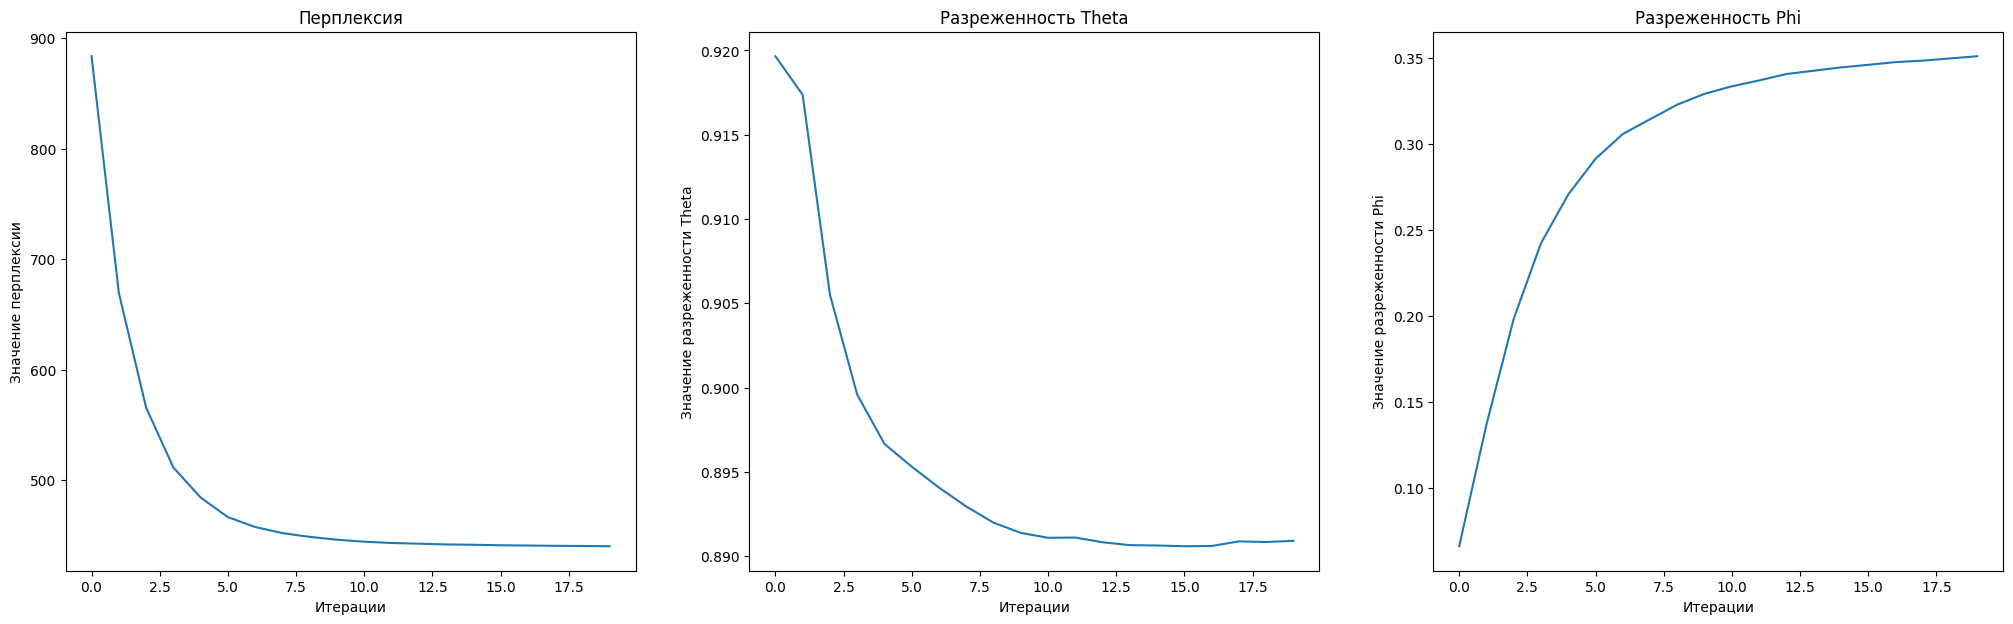

In [435]:
fig = plt.figure(figsize=(25, 7))

ax1 = plt.subplot(1, 3, 1)
ax1.plot(model.score_tracker["perplexity_score"].value, label='Перплексия')
ax1.set_title('Перплексия')
ax1.set_xlabel('Итерации')
ax1.set_ylabel('Значение перплексии')

ax2 = plt.subplot(1, 3, 2)
ax2.plot(model.score_tracker["sparsity_theta_score"].value, label='Разреженность Theta')
ax2.set_title('Разреженность Theta')
ax2.set_xlabel('Итерации')
ax2.set_ylabel('Значение разреженности Theta')

ax3 = plt.subplot(1, 3, 3)
ax3.plot(model.score_tracker["sparsity_phi_score"].value, label='Разреженность Phi')
ax3.set_title('Разреженность Phi')
ax3.set_xlabel('Итерации')
ax3.set_ylabel('Значение разреженности Phi')

plt.show()

In [436]:
def prepare_vis_data():
    phi = model.get_phi()
    theta = model.get_theta().to_numpy().T
    theta = theta / theta.sum(axis=1, keepdims=1)

    data = {'topic_term_dists': phi.to_numpy().T,
            'doc_topic_dists': theta,
            'doc_lengths': n_wd.sum(axis=0).tolist(),
            'vocab': phi.T.columns,
            'term_frequency': n_wd.sum(axis=1).tolist()}
    return data

In [438]:
model_data = prepare_vis_data()
model_vis = pyLDAvis.prepare(**model_data)

pyLDAvis.save_html(model_vis, 'lenta_bigartm_vis.html')

Отрисуем 13 топиков:

In [349]:
pyLDAvis.display(model_vis)